# Accessing GEDI L4A Dataset with NASA OPeNDAP in the Cloud
 This code below was adopted from the code developed by NASA team to get te data from the NASA OPeNDAP Hyrax and via NASA CMR API. The full code can be accessed via "https://github.com/ornldaac/gedi_tutorials/blob/main/access_gedi_l4a_hyrax.ipynb". 

In [1]:
# import modules
%matplotlib inline
import os
from os import path
from glob import glob
import requests
import datetime as dt 
import pandas as pd
import geopandas as gpd
import contextily as ctx
import netCDF4 as nc
from matplotlib import pyplot as plt
from pydap.cas.urs import setup_session
from shapely.ops import orient
from IPython import display
from requests.adapters import HTTPAdapter, Retry
import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('mode.chained_assignment', None)
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Creating the path to the GEDI data
ROOT_PATH = os.path.join("E:\GEDI_biomass")
# Creating the path to the GEDI data
indir = os.path.join(ROOT_PATH, "data","raw","polygons","USDA_proposal")
os.listdir(indir)

['pres_only_unnamed_buff.geojson',
 'recovery_treat_bms_pres_only_unnamed_buff.csv',
 'recovery_treat_bms_wildfire_only_buf.csv',
 'recovery_treat_bms_wildfire_plus_pres_buf.csv',
 'RMNP.geojson',
 'SR_CP_c.geojson',
 'wildfire_only_buf.geojson',
 'wildfire_plus_pres_buf.geojson']

In [3]:
polyfiles = [g for g in os.listdir(indir) if g.endswith('.geojson')]  # List all GEDI L2B .h5 files in inDir
polyfiles

['pres_only_unnamed_buff.geojson',
 'RMNP.geojson',
 'SR_CP_c.geojson',
 'wildfire_only_buf.geojson',
 'wildfire_plus_pres_buf.geojson']

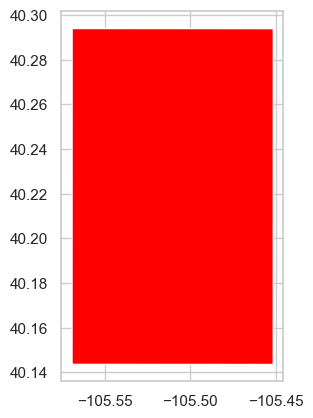

In [5]:
i=1
polyfiles[i]
os.path.join(indir,polyfiles[i])
aca = gpd.read_file(os.path.join(indir,polyfiles[i])) 
aca.crs = "EPSG:4326"
aca.geometry = aca.geometry.apply(orient, args=(1,))
ax= aca.plot(color='red')

In [6]:
# Setting up the Earthdata URS Login session. 
# Get account here https://urs.earthdata.nasa.gov/
# Replace username and password with your credentials

username = "username" # your username in NASA earthdata search log in
password= "password" # your password in NASA earthdata search log in
session = setup_session(username, password, check_url="https://opendap.earthdata.nasa.gov/")

In [7]:
# variables of interests
variables = ['agbd', 'l4_quality_flag', 'land_cover_data/pft_class']

# beams of interest
beams = ['BEAM0000', 'BEAM0001', 'BEAM0010', 'BEAM0011', 'BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']

wildfire_plus_pres_buf.geojson
Total granules found:  46
1
429
420
409
403
396
390
376
369
2
470
453
443
436
428
426
412
401
3
386
393
406
409
401
405
410
428
4
528
517
521
518
493
478
457
442
5
181
219
236
259
291
310
323
334
6
0
0
0
0
0
0
0
0
7
422
408
393
363
334
297
194
35
8
316
330
339
347
370
380
387
400
9
384
409
424
442
469
496
501
531
10
405
425
437
442
444
456
452
456
11
266
239
203
48
0
0
0
0
12
0
0
0
0
0
0
205
259
13
357
354
350
348
339
331
326
311
14
415
432
437
442
454
453
457
454
15
544
547
546
546
536
529
522
520
16
346
348
343
334
329
317
291
280
17
0
0
0
0
0
0
0
0
18
262
291
304
318
332
340
348
369
19
538
542
541
543
549
547
542
532
20
113
143
159
180
226
241
275
298
21
520
511
498
483
473
449
432
438
22
0
0
0
0
0
0
0
0
23
407
390
367
340
295
224
17
0
24
317
301
286
265
231
152
20
0
25
303
340
350
377
415
433
456
472
26
345
354
365
385
395
405
409
405
27
44
0
0
0
0
0
0
0
28
349
344
349
341
334
328
314
292
29
367
340
321
288
70
0
0
0
30
0
0
0
0
0
0
0
0
31
407
397
394
3

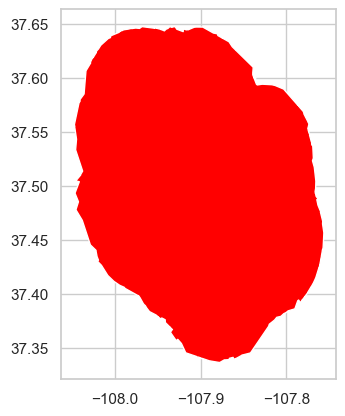

In [9]:
for i in range (2,3):
    print(polyfiles[i])
    aca = gpd.read_file(os.path.join(indir,polyfiles[i])) 
    aca.crs = "EPSG:4326"
    aca.geometry = aca.geometry.apply(orient, args=(1,))

#world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
#base = world[world.name == 'United States of America'].plot(color='white', edgecolor='black', figsize  = (7, 7))
#ax= aca.plot(ax=base, color='red')

    ax= aca.plot(color='red')
    
        # setting up maximum retries to get around Hyrax 500 error
    retries = Retry(total=50, backoff_factor=0.1, status_forcelist=[ 500, 502, 503, 504 ])
    session.mount('https://', HTTPAdapter(max_retries=retries))

    
    # GEDI L4A DOI 
    doi = '10.3334/ORNLDAAC/2056'

    # CMR API base url
    cmrurl='https://cmr.earthdata.nasa.gov/search/' 
    doisearch = f"{cmrurl}collections.json?doi={doi}"
    concept_id = requests.get(doisearch).json()['feed']['entry'][0]['id']

    # defining geojson
    geojson = {"shapefile": (os.path.join(indir,polyfiles[i]), aca.geometry.to_json(), "application/geo+json")}
    page_num = 1
    page_size = 2000 # CMR page size limit

    # time bound for 2020
    start_date = dt.datetime(2019, 1, 1) # specify your own start date
    end_date = dt.datetime(2022, 12, 31)  # specify your end start date

    # CMR formatted start and end times
    dt_format = '%Y-%m-%dT%H:%M:%SZ'
    temporal_str = start_date.strftime(dt_format) + ',' + end_date.strftime(dt_format)

    opendap_arr = []
  
    
    out_csv = os.path.join(indir,("recovery_treat_bms_"+ os.path.splitext(polyfiles[i])[0]+ ".csv"))
        # setting header variables
    headers = ['lat_lowestmode', 'lon_lowestmode', 'elev_lowestmode', 'shot_number']
    headers.extend(variables)

    with open(out_csv, "w") as f:
        f.write(','.join(headers)+'\n')

    while True:

         # defining parameters
        cmr_param = {
            "collection_concept_id": concept_id, 
            "temporal": temporal_str,
            "page_size": page_size,
            "page_num": page_num,
            "simplify-shapefile": 'true' # this is needed to bypass 5000 coordinates limit of CMR
        }

        granulesearch = f"{cmrurl}granules.json"
        response = requests.post(granulesearch, data=cmr_param, files=geojson)
        granules = response.json()['feed']['entry']
        if granules:
            for g in granules:          
                # Get OPeNDAP URLs
                for links in g['links']:
                    if 'title' in links and links['title'].startswith('OPeNDAP'):
                        opendap_url = links['href']
                        opendap_arr.append(opendap_url)
            page_num += 1
        else: 
            break

    total_granules = len(opendap_arr)
    print ("Total granules found: ", total_granules)

    c=0
    for g_name in opendap_arr:
        c += 1
        print(c)
        # loop over all beams
        for beam in beams:       
            # 1. Retrieving lat, lon coordinates for the file
            hyrax_url = f"{g_name}.dap.nc4?dap4.ce=/{beam}/lon_lowestmode;/{beam}/lat_lowestmode"
            r = session.get(hyrax_url)
            if (r.status_code != 400):
                ds = nc.Dataset('hyrax', memory=r.content)
                lat = ds[beam]['lat_lowestmode'][:]
                lon = ds[beam]['lon_lowestmode'][:]
                ds.close()
                df = pd.DataFrame({'lat_lowestmode': lat, 'lon_lowestmode': lon}) # creating pandas dataframe  

                # 2. Subsetting by bounds of the area of interest
                # converting to geopandas dataframe
                gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon_lowestmode, df.lat_lowestmode)) 
                gdf_aca = gdf[gdf['geometry'].within(aca.geometry[0])]  
                print(len(gdf_aca))
                if not gdf_aca.empty:
                                        # creating empty columns for variables
                    for v in headers[2:]:
                        gdf_aca[v] = None
                    # 3. retrieving variables of interest, agbd, agbd_t in this case.
                    # We are only retriving the shots within subset area.
                    for _, df_gr in gdf_aca.groupby((gdf_aca.index.to_series().diff() > 1).cumsum()):
                        i = df_gr.index.min()
                        j = df_gr.index.max()
                        for v in headers[2:]:
                            try:
                                var_s = f"/{beam}/{v}%5B{i}:{j}%5D"
                                hyrax_url = f"{g_name}.dap.nc4?dap4.ce={var_s}"
                                r = session.get(hyrax_url)
                                if (r.status_code != 400):
                                    ds = nc.Dataset('hyrax', memory=r.content)
                                    gdf_aca.loc[i:j, (v)] = ds[beam][v][:]
                                    ds.close()
                            except:
                                pass

                    # saving the output file
                    gdf_aca.to_csv(out_csv, mode='a', index=False, header=False, columns=headers)

#                     #plotting the shots
#                     gdf_aca.crs = "EPSG:4326"
#                     gdf_aca.to_crs(epsg=3857).plot(alpha=0.01, ax=ax, linewidth=0)
#                     ax.set_title(f"Downloading {c} of {total_granules}... {g_name.rsplit('/', 1)[-1]} / {beam}")
#                     display.display(plt.gcf())
#                     display.clear_output(wait=True)


    # plotting the area of interest
#     ax=aca.to_crs(epsg=3857).plot(figsize=(5, 6), alpha=0.3)
#     ctx.add_basemap(ax)
#     ax.set_title("Starting download...")
#     display.display(plt.gcf())
#     display.clear_output(wait=True)


iI = 14, and I =25 has problems (21. shp and 31.shp)

# 2. Access the variables of interest for the subset area via OPeNDAP
Access to NASA OPeNDAP requires NASA Earthdata authentication. Please set up a new account if you do not already have a NASA Earthdata account. We will use Python's pydap module to set up the authentication.

In [16]:
# reading the csv file created in the last step
l4a_df = pd.read_csv(out_csv)
l4a_df.head()

,lat_lowestmode,lon_lowestmode,elev_lowestmode,shot_number,agbd,l4_quality_flag,land_cover_data/pft_class
0,36.369440,-107.014082,7921.979492,20340000300156127,-9999.0,0,1
1,36.369097,-107.013605,7921.271973,20340000300156128,-9999.0,0,1
2,36.368754,-107.013129,7921.928223,20340000300156129,-9999.0,0,1
3,36.368411,-107.012652,7921.577637,20340000300156130,-9999.0,0,1
4,36.368068,-107.012175,7922.045898,20340000300156131,-9999.0,0,1


We can now plot the distribution of the AGBD by plant functional types (PFTs) for the good quality shots in the ACA region.

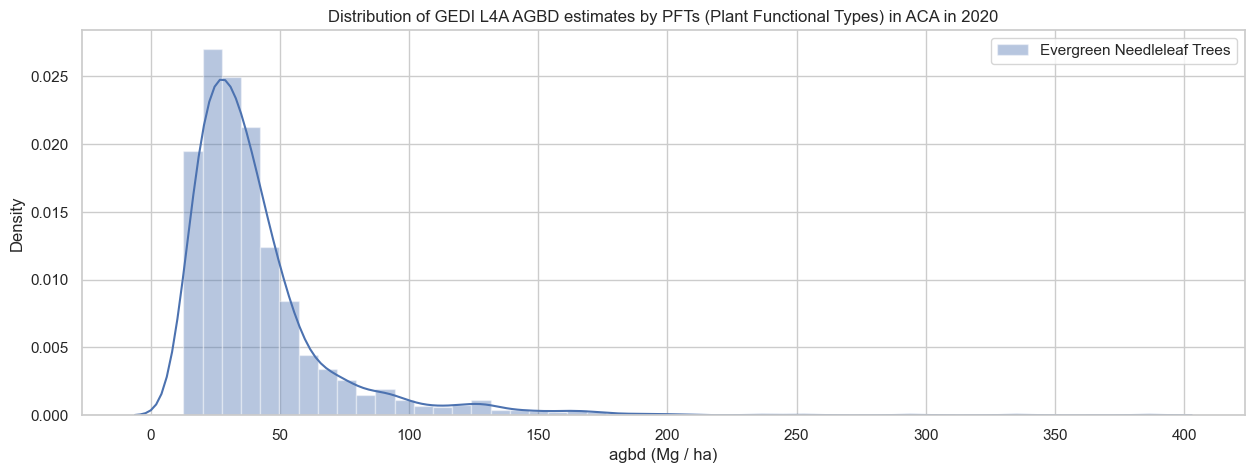

<Figure size 640x480 with 0 Axes>

In [17]:
# MCD12Q1 PFT types
pft_legend = {0 : 'Water Bodies', 1: 'Evergreen Needleleaf Trees', 2: 'Evergreen Broadleaf Trees', 
              3: 'Deciduous Needleleaf Trees',  4: 'Deciduous Broadleaf Trees', 5: 'Shrub', 6: 'Grass',
              7: 'Cereal Croplands', 8: 'Broadleaf Croplands', 9: 'Urban and Built-up Lands', 
              10: 'Permanent Snow and Ice', 11: 'Barren', 255: 'Unclassified'}

# creating mask with good quality shots and trees/shrubs pft class
mask = (l4a_df['l4_quality_flag']==1) & (l4a_df['land_cover_data/pft_class'] <= 5 ) 
plt.figure(figsize=(15,5))
ax = l4a_df[mask].groupby('land_cover_data/pft_class')['agbd'].\
            apply(lambda x: sns.distplot(x, label = pft_legend[x.name], hist=True))
plt.xlabel('agbd (Mg / ha)')
plt.title('Distribution of GEDI L4A AGBD estimates by PFTs (Plant Functional Types) in ACA in 2020')
plt.legend()
plt.show()
plt.savefig("test.png")

Let's also plot how the AGBD is distributed across elevation ranges for different PFTs.

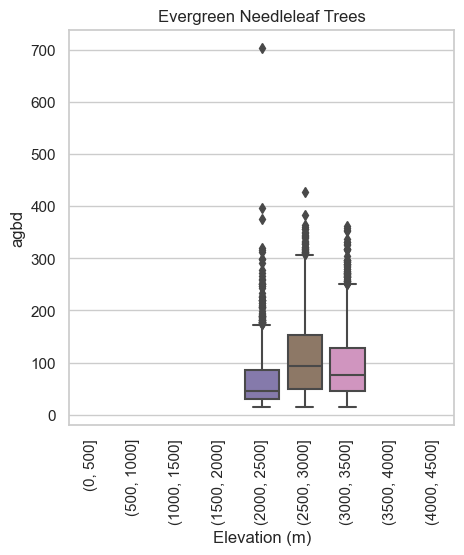

In [23]:
l4a_df['elev_bin']=pd.cut(l4a_df['elev_lowestmode'], bins =range(0, 5000, 500))
g = sns.catplot(x = "elev_bin", y = "agbd", data = l4a_df[mask], col="land_cover_data/pft_class", kind="box")
g.set_xticklabels(rotation=90)
g.set_titles("{col_name}")
for ax in g.axes.flat:
    ax.set_title(pft_legend[int(float(ax.get_title()))])
g.set_axis_labels("Elevation (m)")
sns.despine(top=False, right=False, left=False, bottom=False, offset=None, trim=False)
plt.savefig("agbd_category.png")